<a href="https://colab.research.google.com/github/baochi0212/ML_project_midterm-/blob/master/Inference_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#set up


In [ ]:
!wget http://shuoyang1213.me/WIDERFACE/support/bbx_annotation/wider_face_split.zip

--2022-07-06 06:11:04--  http://shuoyang1213.me/WIDERFACE/support/bbx_annotation/wider_face_split.zip
Resolving shuoyang1213.me (shuoyang1213.me)... 192.30.252.153, 192.30.252.154
Connecting to shuoyang1213.me (shuoyang1213.me)|192.30.252.153|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3591642 (3.4M) [application/zip]
Saving to: ‘wider_face_split.zip’

wider_face_split.zi 100%[===================>]   3.42M  --.-KB/s    in 0.08s   

2022-07-06 06:11:04 (42.5 MB/s) - ‘wider_face_split.zip’ saved [3591642/3591642]



In [ ]:
!pip install facenet-pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 29.0 MB/s 


In [ ]:
!unzip /content/wider_face_split.zip

Archive:  /content/wider_face_split.zip
   creating: wider_face_split/
  inflating: wider_face_split/readme.txt  
  inflating: wider_face_split/wider_face_test.mat  
  inflating: wider_face_split/wider_face_test_filelist.txt  
  inflating: wider_face_split/wider_face_train.mat  
  inflating: wider_face_split/wider_face_train_bbx_gt.txt  
  inflating: wider_face_split/wider_face_val.mat  
  inflating: wider_face_split/wider_face_val_bbx_gt.txt  


In [ ]:
!pip install --upgrade gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for gdown: filename=gdown-4.5.1-py3-none-any.whl size=14951 sha256=6a7907b120812d2a145b092a01d657b07d7025df2cc455d487ed8c8f0d1e3bd5
  Stored in directory: /root/.cache/pip/wheels/3d/ec/b0/a96d1d126183f98570a785e6bf8789fca559853a9260e928e1
Successfully built gdown
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0


In [ ]:
!mkdir data

In [ ]:
!gdown --id 15hGDLhsx8bLgLcIRD5DhYt5iBxnjNF1M #training file

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=15hGDLhsx8bLgLcIRD5DhYt5iBxnjNF1M
To: /content/WIDER_train.zip
100% 1.47G/1.47G [00:09<00:00, 159MB/s]


In [ ]:
!gdown --id 1HIfDbVEWKmsYKJZm4lchTBDLW5N7dY5T #testing file

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1HIfDbVEWKmsYKJZm4lchTBDLW5N7dY5T
To: /content/WIDER_test.zip
100% 1.84G/1.84G [00:19<00:00, 93.8MB/s]


In [ ]:
!unzip /content/WIDER_test.zip
!unzip /content/WIDER_train.zip

In [ ]:
!mv /content/WIDER_test /content/data
!mv /content/WIDER_train /content/data
!mv /content/wider_face_split /content/data

In [ ]:
import cv2
from PIL import Image
import os 
from glob import glob
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
from facenet_pytorch import MTCNN, InceptionResnetV1
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F


#DETECTION TRIAL

In [ ]:
with open('/content/data/wider_face_split/wider_face_train_bbx_gt.txt') as f:
  box_dict = {} 
  while True:
    line = f.readline()
    path = os.path.join('/content/data/WIDER_train/images', line.strip())
    # if line.strip() == '0--Parade/0_Parade_Parade_0_337.jpg':

    if os.path.exists(path):
      # print('line', line)
      box_dict[path] = []
      num_people = f.readline()
      #End of file
      if len(num_people) == 0:
        break
      num_people = int(num_people)
      if num_people == 0:
        num_people += 1
      box_dict[path].append(int(num_people))
      # print(num_people)
      for i in range(int(num_people)):
        box = f.readline().split()
        x1 = int(box[0])
        y1 = int(box[1])
        x2 = x1 + int(box[2])
        y2 = y1 + int(box[3])
        box_dict[path].append([x1, y1, x2, y2])
      # print(f.readline())
      # break
    else:
      print(path)
      num_people = int(f.readline())
      for i in range(num_people):
        f.readline()
      print(f.readline())
      break




In [ ]:
path = list(box_dict.keys())[20]
path

'/content/data/WIDER_train/images/0--Parade/0_Parade_Parade_0_1014.jpg'

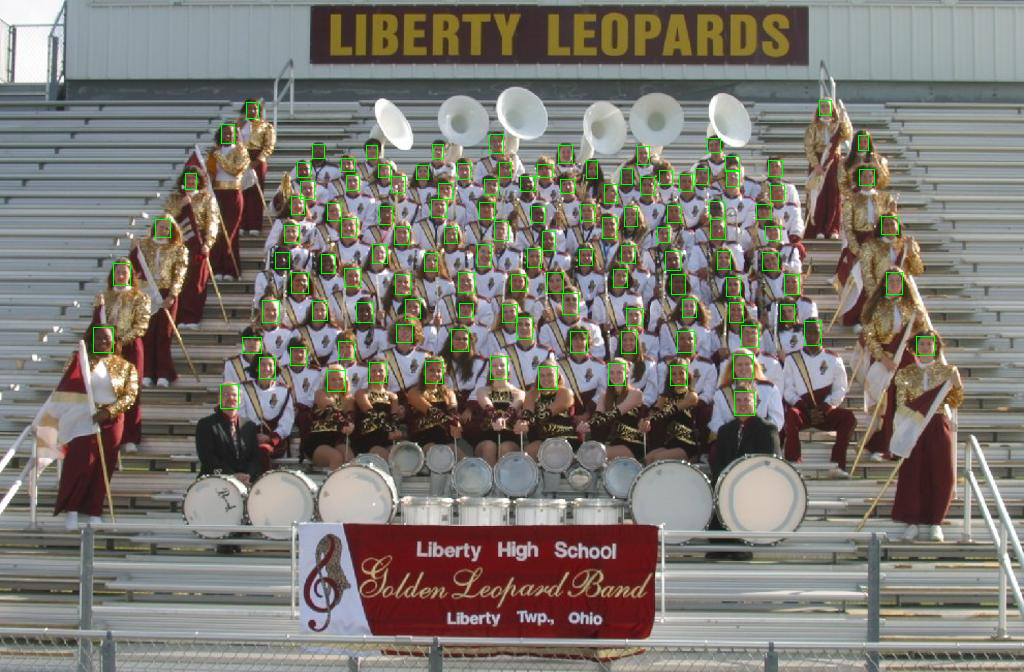

In [ ]:
#plot:
path = list(box_dict.keys())[30]
image = cv2.imread(path)
num_people = box_dict[path][0]
for i in range(num_people):
  x1, y1, x2, y2 = box_dict[path][i+1]
  bgr = (0, 255, 0)
  cv2.rectangle(image, (x1, y1), (x2, y2), bgr, 1)
cv2_imshow(image)


In [ ]:
def gen_tensor(path, boxes, num_people):
  #image
  image = Image.open(path)
  image = transforms.ToTensor()(image)
  #label:
  target = {}
  labels = torch.tensor([0 for i in range(num_people)])
  boxes = torch.tensor(boxes)
  target['boxes'] = boxes 
  target['labels'] = labels
  return image, target

class Face_set(Dataset):
  def __init__(self, box_dict):
    self.box_dict = box_dict

  def __getitem__(self, idx):
    path = list(self.box_dict.keys())[idx]
    num_people = self.box_dict[path][0]
    boxes = self.box_dict[path][1:]
    image, target = gen_tensor(path, boxes, num_people)
    return image, target

  def __len__(self):
    return len(list(self.box_dict.keys()))


dataset = Face_set(box_dict)
def collate_fn(batch):
    return list(zip(*batch))
dataloader = DataLoader(dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
#pytorch use torch stack in default so we need the colalte fn

# pretrained


In [ ]:
import requests
url = "https://cdn.bongdaplus.vn/Assets/Media/2022/06/02/66/messi.jpg"
r = requests.get(url)
with open("messi.jpg", "wb") as f:
  f.write(r.content)

In [ ]:
%matplotlib inline

In [ ]:
mtcnn = MTCNN(keep_all=True, post_process=False)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


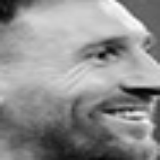

In [ ]:
image = Image.open("messi.jpg")
# image = transforms.Resize((224, 224))(image)
# image
boxes, probs = mtcnn.detect(image) #get the boxes
face = mtcnn(image)[0] #get the faces
img = transforms.Resize((48, 48))((transforms.ToTensor()((Image.fromarray(face.permute(1, 2, 0).numpy().astype(np.uint8)).convert('L')))))
Image.fromarray(face.permute(1, 2, 0).numpy().astype(np.uint8)).convert('L')

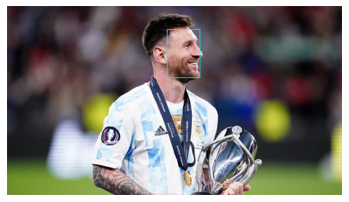

In [ ]:
image = np.asarray(image)
for box in boxes:
  x1, y1, x2, y2 = box
  rgb = (0, 250, 250)
  cv2.rectangle(image, (x1, y1), (x2, y2), rgb, 1) #layer of box

plt.axis(False)
plt.imshow(image)
plt.show()

#checkpoints

In [ ]:
!gdown --id 1Oy_9YmpkSKX1Q8jkOhJbz3Mc7qjyISzU

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1Oy_9YmpkSKX1Q8jkOhJbz3Mc7qjyISzU
To: /content/PrivateTest_model.t7
100% 80.2M/80.2M [00:01<00:00, 78.5MB/s]


# VGG19

In [ ]:
cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}


class VGG(nn.Module):
    def __init__(self, vgg_name):
        super(VGG, self).__init__()
        self.features = self._make_layers(cfg[vgg_name])
        self.classifier = nn.Linear(512, 7)

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = F.dropout(out, p=0.5, training=self.training)
        out = self.classifier(out)
        return out

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)

In [ ]:
vgg = VGG('VGG19')

In [ ]:
vgg.load_state_dict(torch.load('/content/PrivateTest_model.t7', map_location=torch.device('cpu'))['net'])

<All keys matched successfully>

#INFERENCE 

In [ ]:
img = torch.concat([img, img, img], dim=0)

In [ ]:
cls_dict = dict([(0, "Angry"), (1, "Disgust"),(2, "Fear"), (3, "Happy"), (4, "Sad"), (5, "Surprise"), (6, "Neutral")])
result_dict = dict([(cls_dict[i], 0) for i in range(7)])
result = F.softmax(vgg(img.float().unsqueeze(0)))
for idx, i in enumerate(result[0, :]):
  result_dict[cls_dict[idx]] = i.item()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until


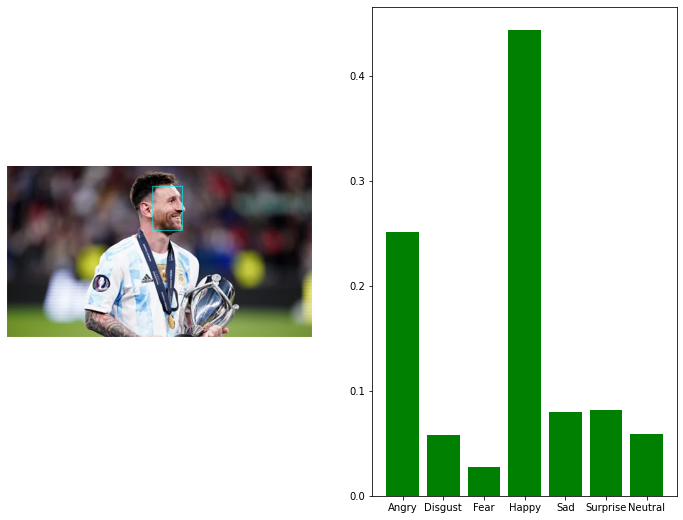

In [ ]:
fig, (ax1, ax2) = plt.subplots(figsize=(12, 9), nrows=1, ncols=2)
ax1.imshow(image)
ax1.axis(False)
ax2.bar(result_dict.keys(), result_dict.values(), color='green')
plt.show()